## Organ differences by Milo - lymphoid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
from itertools import compress
import random
import joblib as jl
import matplotlib.patches as mpatches

In [4]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [5]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/organ_milo_analysis_LYMPHOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [6]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [7]:
%load_ext rpy2.ipython


In [8]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [9]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load milo neighbourhoods
Computed in `src/7_differential_abundance`

In [9]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="LYMPHOID"

In [10]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))

In [11]:
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

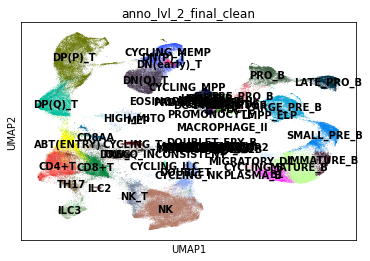

In [12]:
sc.pl.umap(adata, color='anno_lvl_2_final_clean', legend_loc='on data')

In [28]:
## Update annotation
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

### Make neighbourhoods
Larger neighbourhoods than for analysis in time (more samples per condition)

In [13]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

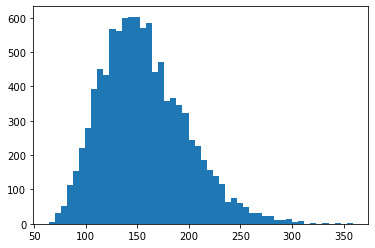

In [14]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50);

### Test

In [15]:
adata.obs['organ'] = adata.obs['organ'].astype("category")
milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor', 'organ'])
adata.uns['nhood_adata'].var['organ'] = adata.uns['nhood_adata'].var['organ'].astype('category')
all_organs = adata.obs.organ.unique().tolist()
design = '~ method + correction_factor + organ'

## Calculate logFC and SpatialFDR within each organ
milo_res_dict = {}

In [16]:
for org in all_organs:
    print(org)
    if org == adata.uns['nhood_adata'].var.organ.cat.categories[0]:
        nhood_adata = adata.uns['nhood_adata'].copy()
        new_cats = nhood_adata.var.organ.cat.categories[1:].tolist()
        new_cats.append(org)
        nhood_adata.var.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.obs.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.uns['nhood_adata'] = nhood_adata.copy()
#     _milo_test_organ_abundance(adata, org, design)
    milo.DA_nhoods(adata, design=design, model_contrasts='organ{o}'.format(o=org))
    milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

SK
SP
YS
LI
TH
GU
BM
KI


In [17]:
## Collapse results
logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
for k,v in milo_res_dict.items():
    milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
    milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)

In [21]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
    

In [19]:
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0

In [29]:
## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [30]:
anno_group_lymphoid = {
    "NK cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in org_fc_filtered.nhood_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
   "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_lymphoid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_lymphoid.values(),[])]
anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

In [31]:
org_fc_filtered['anno_group'] = [anno_group_lymphoid_rev[x] for x in org_fc_filtered['nhood_anno']]

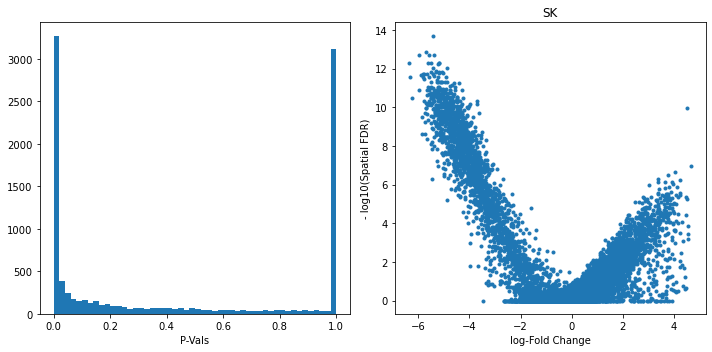

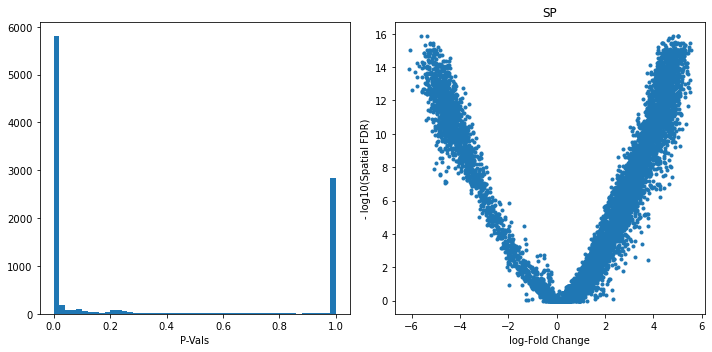

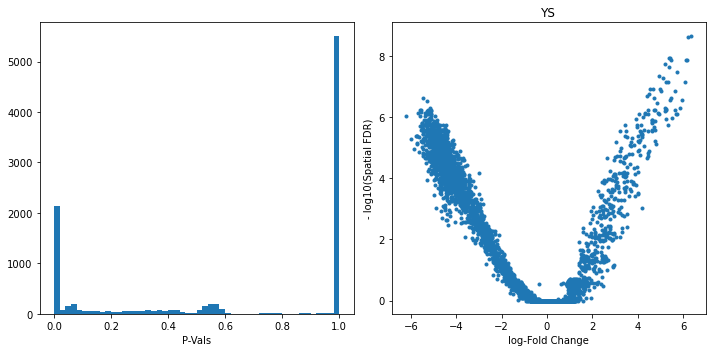

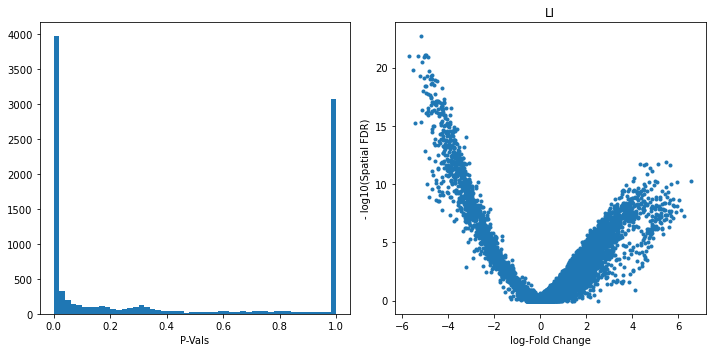

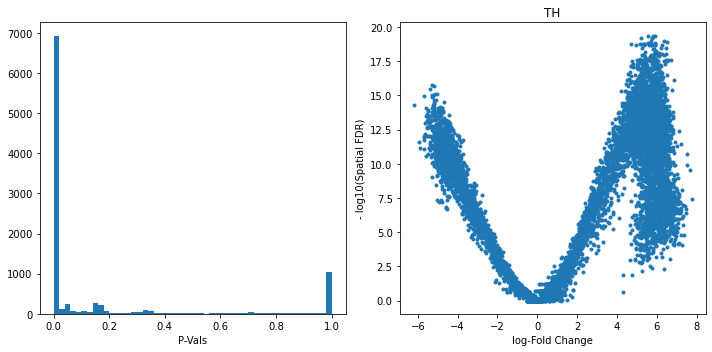

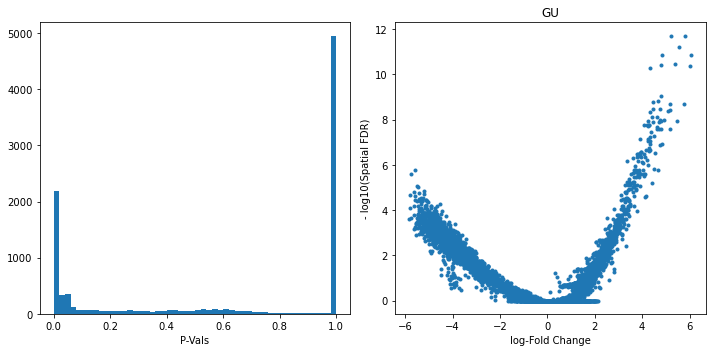

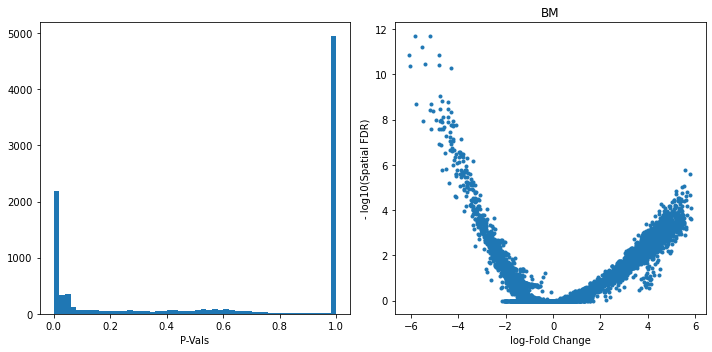

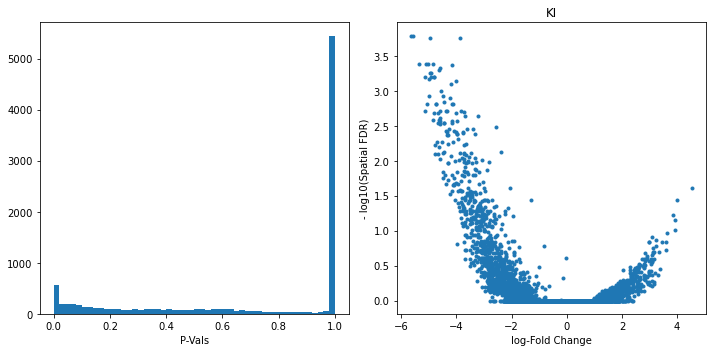

In [32]:
old_figsize = plt.rcParams["figure.figsize"]
for org, milo_res in milo_res_dict.items():
    plt.rcParams["figure.figsize"] = [10,5]
    plt.subplot(1,2,1)
    plt.hist(milo_res.PValue, bins=50);
    plt.xlabel("P-Vals");
    plt.subplot(1,2,2)
    plt.plot(milo_res.logFC, -np.log10(milo_res.SpatialFDR), '.');
    plt.xlabel("log-Fold Change");
    plt.ylabel("- log10(Spatial FDR)");
    plt.title(org);
    plt.tight_layout();
    plt.show()

plt.rcParams["figure.figsize"] = old_figsize

### Plot in embeddings

In [33]:
milopy.utils.build_nhood_graph(adata)

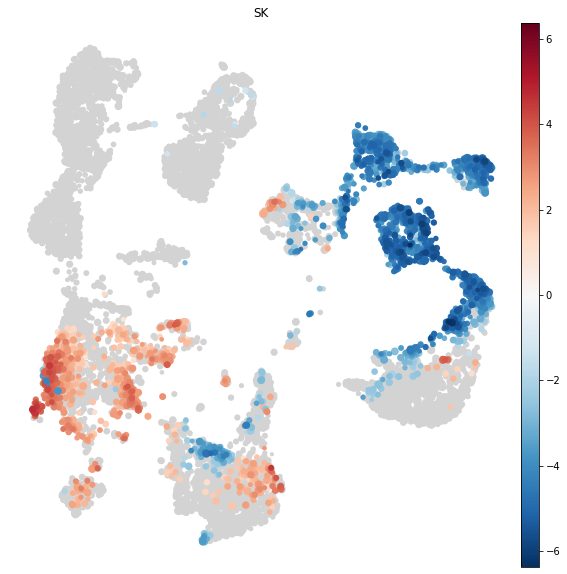

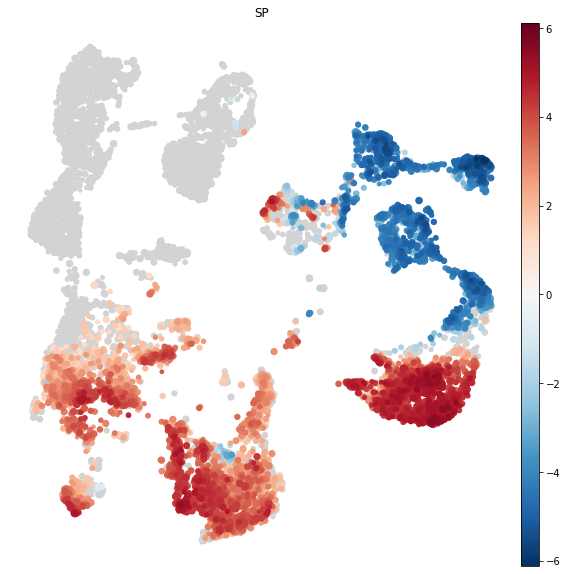

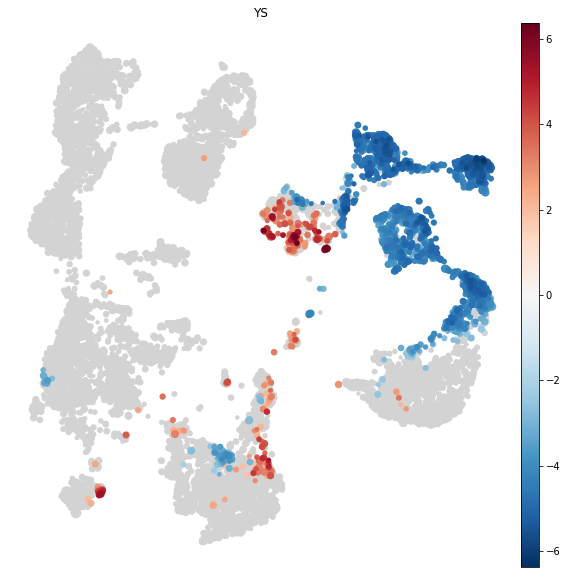

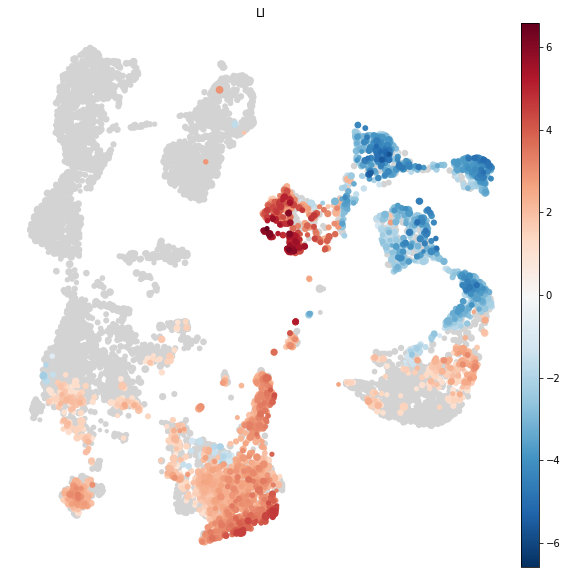

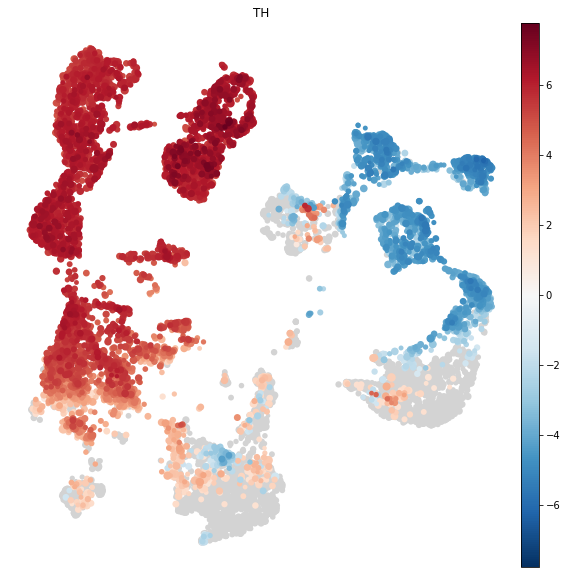

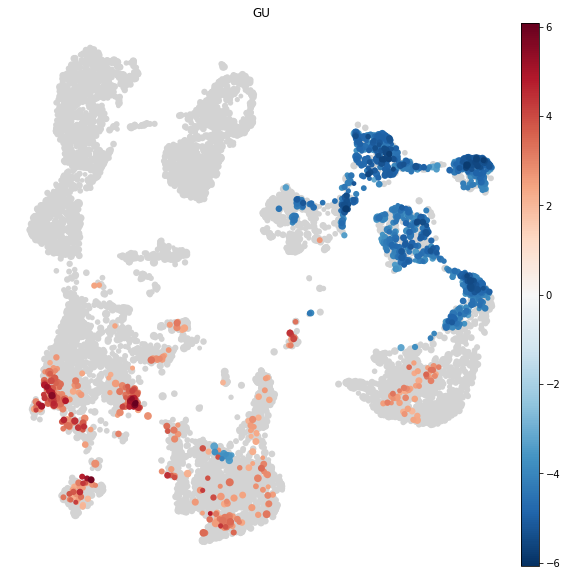

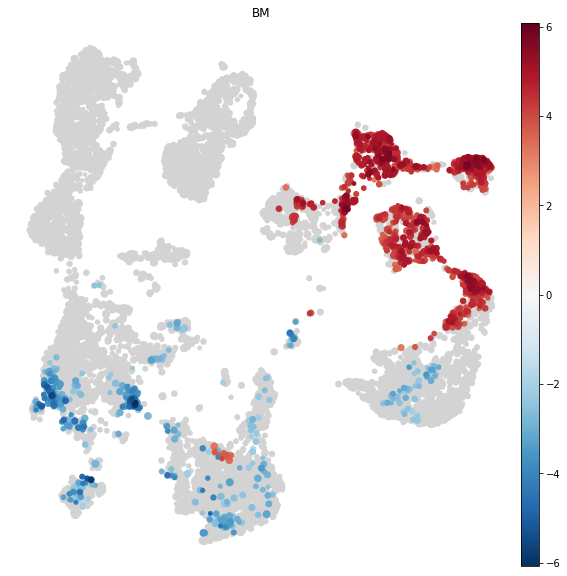

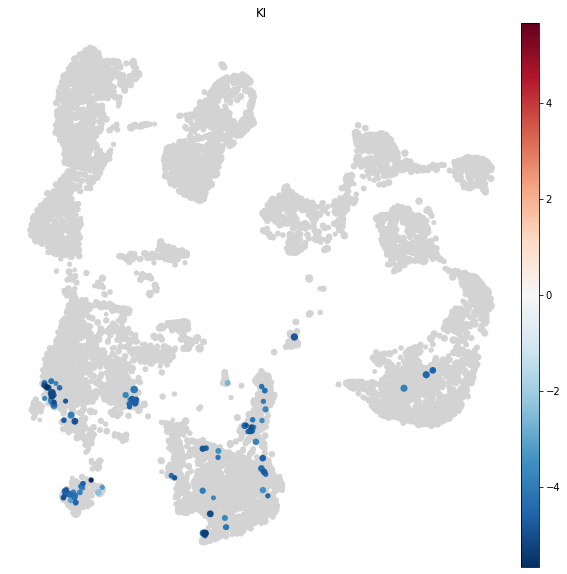

In [34]:
plt.rcParams["figure.figsize"] = [10,10]
milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopl.plot_nhood_graph(adata, alpha=0.01, min_size=1, title=org,  save="milo_nhoods_graph_{o}.png".format(o=org))

In [35]:
alpha = 0.01
min_logFC = 2
min_size=0.5
plot_edges = False
title='ciao'

def plot_nhood_graph_enrichment(nhood_adata, alpha = 0.01,
    min_logFC = 2,
    min_size=0.5,
    plot_edges = False,
    title='ciao',**kwargs):
#     nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
    nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
    nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < 0, "graph_color"] = np.nan

    ## Plotting order - extreme logFC on top
    nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(), "abs_logFC"] = np.nan
    ordered = nhood_adata.obs.sort_values('abs_logFC', na_position='first').index
    nhood_adata = nhood_adata[ordered]

#     vmax = np.max([nhood_adata.obs["graph_color"].max(), abs(nhood_adata.obs["graph_color"].min())])
    vmin = 0

    sc.pl.embedding(nhood_adata, "X_milo_graph", 
                    color="graph_color", cmap="Reds",
                    size=nhood_adata.obs["Nhood_size"]*min_size, 
                    edges=plot_edges, neighbors_key="nhood",
                    # edge_width = 
                    sort_order=False,
                    frameon=False,
#                     vmax=vmax, 
                    vmin=vmin,
                    title=title,
                    **kwargs
                   )

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


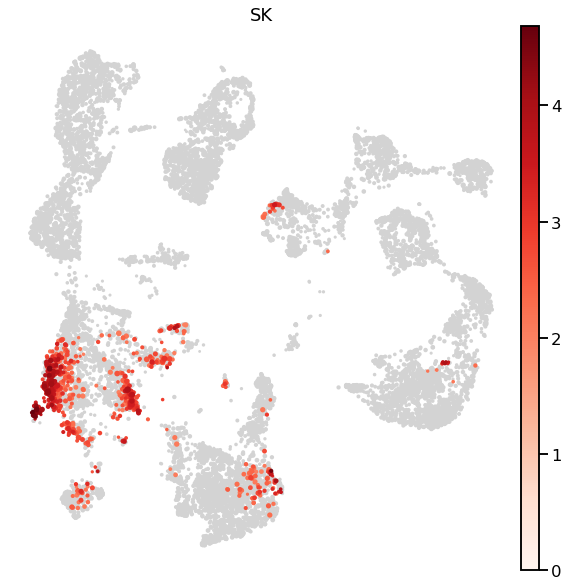

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


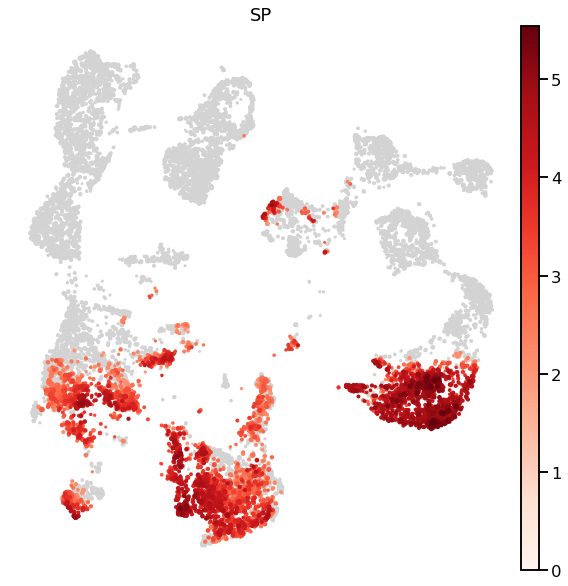

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


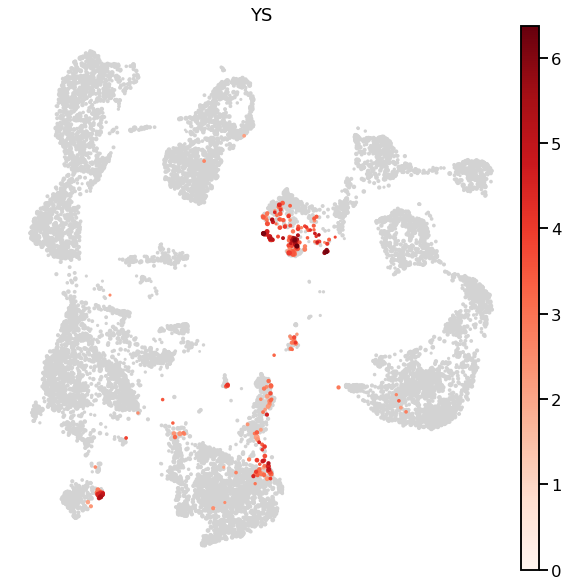

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


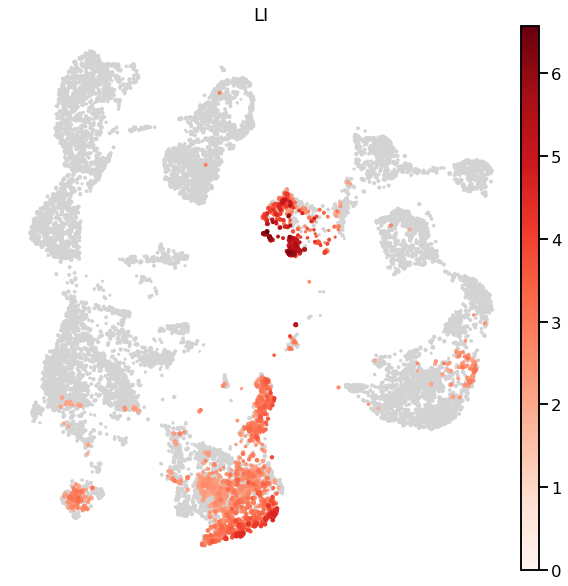

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


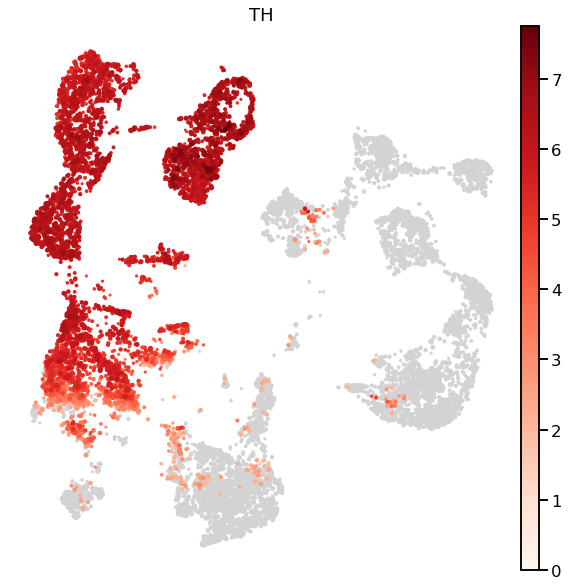

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


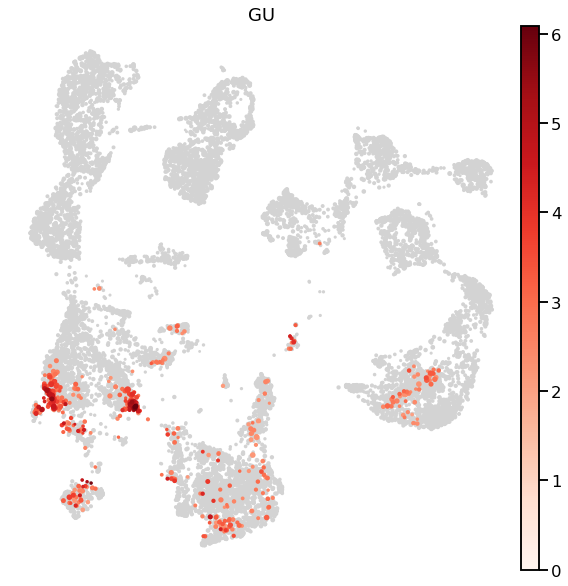

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


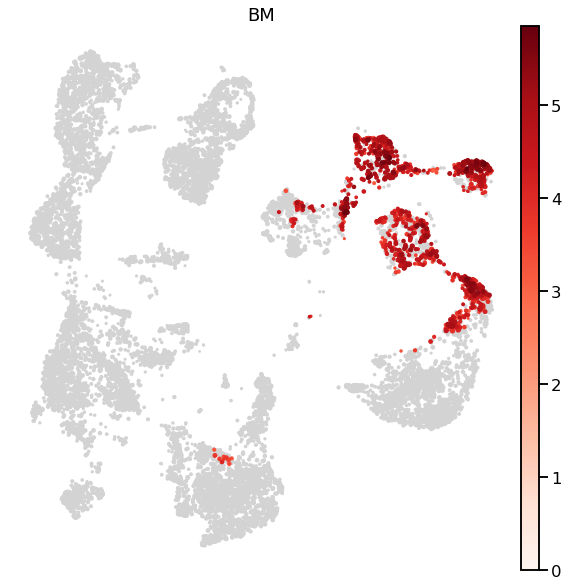

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


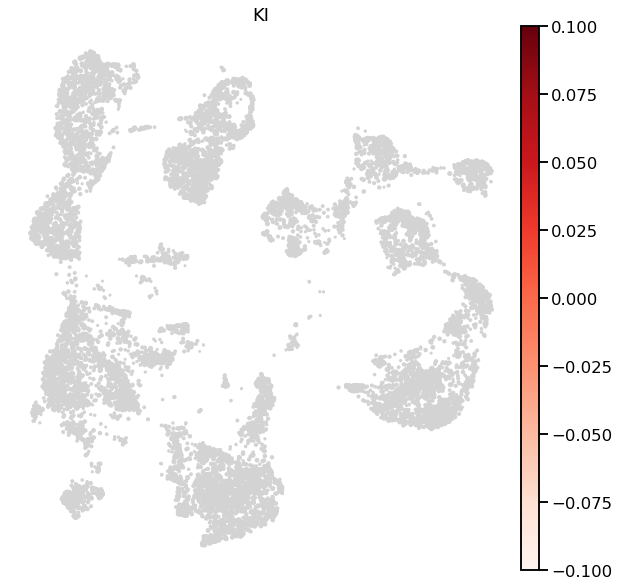

In [36]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")

# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_{o}.pdf'.format(o=org))

### Thymic SP T cells figure

In [ ]:
spt_cells = ["CD4+T", "CD8+T", "TH17", "NK_T", "CD8AA", "ABT(ENTRY)"]

plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
min_size=0.5
nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(spt_cells)].copy()
sc.pl.embedding(nhood_adata, "X_milo_graph", 
                color="nhood_annotation",
                size=nhood_adata.obs["Nhood_size"]*min_size, 
                edges=plot_edges, neighbors_key="nhood",
                # edge_width = 
                sort_order=False,
                frameon=False,
                title='',
                legend_loc="on data",
                save='nhood_graph_spt_anno.pdf'
               )


# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(spt_cells)].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_spt_{o}.pdf'.format(o=org))

### Visualize with beeswarm plot

In [38]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

unique(plot_df$anno_group)

Joining, by = c("Nhood", "organ")
[1] "T cells"     "Progenitors" "other"       "B cells"     "ILCs"       
[6] "NK cells"   


In [39]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c('Progenitors', "ILCs", "NK cells","B cells" ,"T cells")

pl_df <- plot_df %>%
    mutate(logFC=ifelse(logFC > 0, logFC, 0)) %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% anno_group_order)

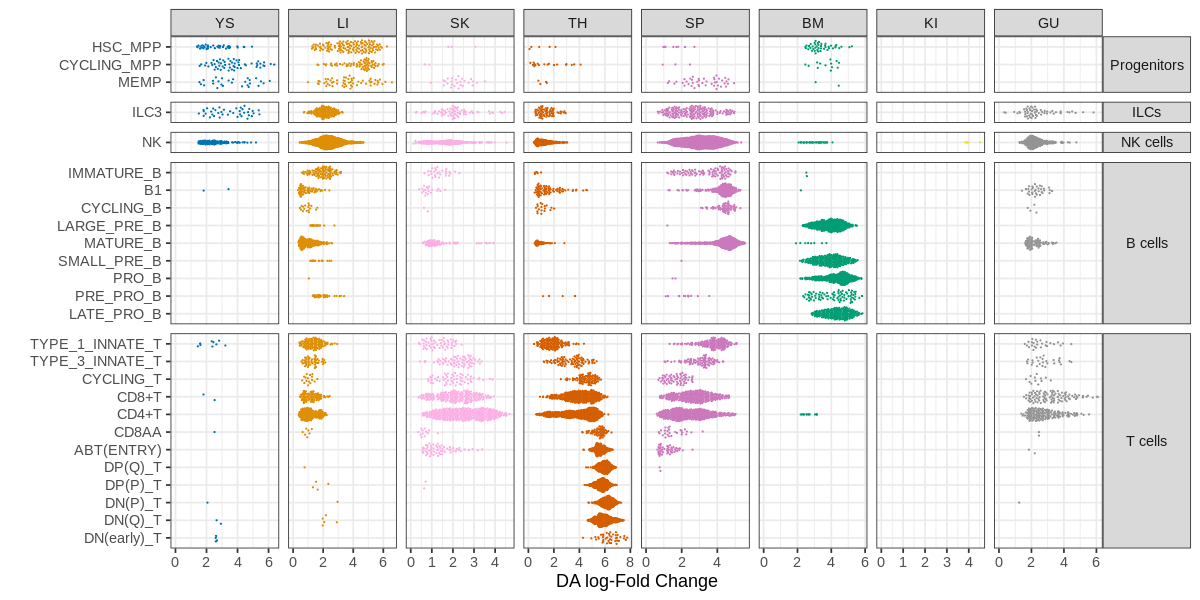

In [40]:
%%R -w 1200 -h 600
alpha=0.1
set.seed(12345)
pl1 <- 
    pl_df %>%
    mutate(organ_color=ifelse((SpatialFDR < alpha) & (logFC > 0), as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
#     geom_quasirandom(size=0.2, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.4, aes(color=organ_color)) +
#     geom_violin(data=. %>% filter(SpatialFDR < alpha), aes(color=organ_color)) +
#     geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    theme_bw(base_size=18) +
    xlab("") + ylab("DA log-Fold Change") +
    theme(strip.text.y=element_text(angle=0))
    
pl1
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

### Visualize with heatmaps

In [41]:
min_lfc = 2
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0
org_fc_filtered.values[org_fc_filtered.values < min_lfc] = 0

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

## Add annotation grouping
anno_group_lymphoid = {
    "NK cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in org_fc_filtered.nhood_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in org_fc_filtered.nhood_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
   "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_lymphoid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_lymphoid.values(),[])]
anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

org_fc_filtered['anno_group'] = [anno_group_lymphoid_rev[x] for x in org_fc_filtered['nhood_anno']]

In [42]:
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

org_fc_filtered["hclust_order"] = np.nan
for a in org_fc_filtered.nhood_anno.unique():
    ## Keep high FCs
    
    df = org_fc_filtered[org_fc_filtered.nhood_anno==a].drop(['nhood_anno', 'anno_group', 'hclust_order'], 1)
    clustering = ward(df.values)
    ordered_ixs = org_fc_filtered.index[org_fc_filtered.nhood_anno==a][leaves_list(clustering)]
    org_fc_filtered.loc[ordered_ixs, 'hclust_order'] = np.arange(sum(org_fc_filtered.nhood_anno==a))

In [43]:
# anno_order = [
#     ## Monocytes
#     'PROMONOCYTE', 
#     'MONOCYTE_I_CXCR4',
#     'MONOCYTE_II_IL1B', 
#     'MONOCYTE_III_CCR2',
#     ## MA
# ]

In [44]:
%%R -i org_fc_filtered -w 1000 -h 500

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood, hclust_order), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 

In [45]:
%%R
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) 

plot_df %>%
arrange(-logFC) %>%
head()
 
    

Joining, by = c("Nhood", "organ")
  Nhood  nhood_anno anno_group hclust_order organ    logFC   SpatialFDR
1  9950 DN(early)_T    T cells            3    TH 7.751081 3.771389e-08
2  9938 DN(early)_T    T cells            2    TH 7.645336 2.936232e-10
3  9937 DN(early)_T    T cells            1    TH 7.521438 1.248817e-10
4  5730 DN(early)_T    T cells            0    TH 7.504288 2.068251e-11
5  2597     DN(Q)_T    T cells           66    TH 7.477701 2.149357e-07
6  5759     DN(Q)_T    T cells           67    TH 7.441340 4.220439e-07


In [46]:
%%R -w 1200 -h 500
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7), layout_heights=c(1,4)){
    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 

    p1 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,nhood_anno)) +
        geom_tile_rast(fill='black') +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        theme_classic(base_size=18) +
        remove_x_axis() +
        ylab("") +
        theme(axis.line.x=element_blank(), strip.background=element_blank(), strip.text=element_blank()) +
        ggtitle(g)

    p2 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
#       scale_fill_gradient(low='#f7f7f7', high='#b2182b', limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhood") +
        theme(strip.background=element_blank(), strip.text=element_blank(), 
              axis.line.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

    (p1 / p2 ) + plot_layout(heights=layout_heights, guides='collect')
    } 
for (g in unique(plot_df$anno_group)){
    plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)) + 
    ggsave(paste0(figdir, "enrichment_hm_", g, '.pdf'), width=15, height=7) +
    ggsave(paste0(figdir, "enrichment_hm_", g, '.png'), width=15, height=7)
}

In [47]:
# %%R -w 1200 -h 1200
# pl_ls <- lapply(unique(plot_df$anno_group), function(g) plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)))
# wrap_plots(pl_ls[1:3], ncol=1) +
#     plot_layout(guides='collect')

In [48]:
%%R -h 1000 -w 800 -o plot_df
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7)){

    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 


    pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood, organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
#         scale_fill_viridis_c(option='magma', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhoods") +
        remove_x_axis() +
        theme(strip.background=element_rect(fill='grey', color=NA),
              strip.text.y.left = element_text(angle = 0),
              strip.text.x = element_text(angle = 0)
              ) +
        ggtitle(g)

}

# for (g in unique(plot_df$anno_group)){
#     plot_organ_FC_hm_group(plot_df, g) + 
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.pdf'), width=8, height=10) +
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.png'), width=8, height=10)
# }

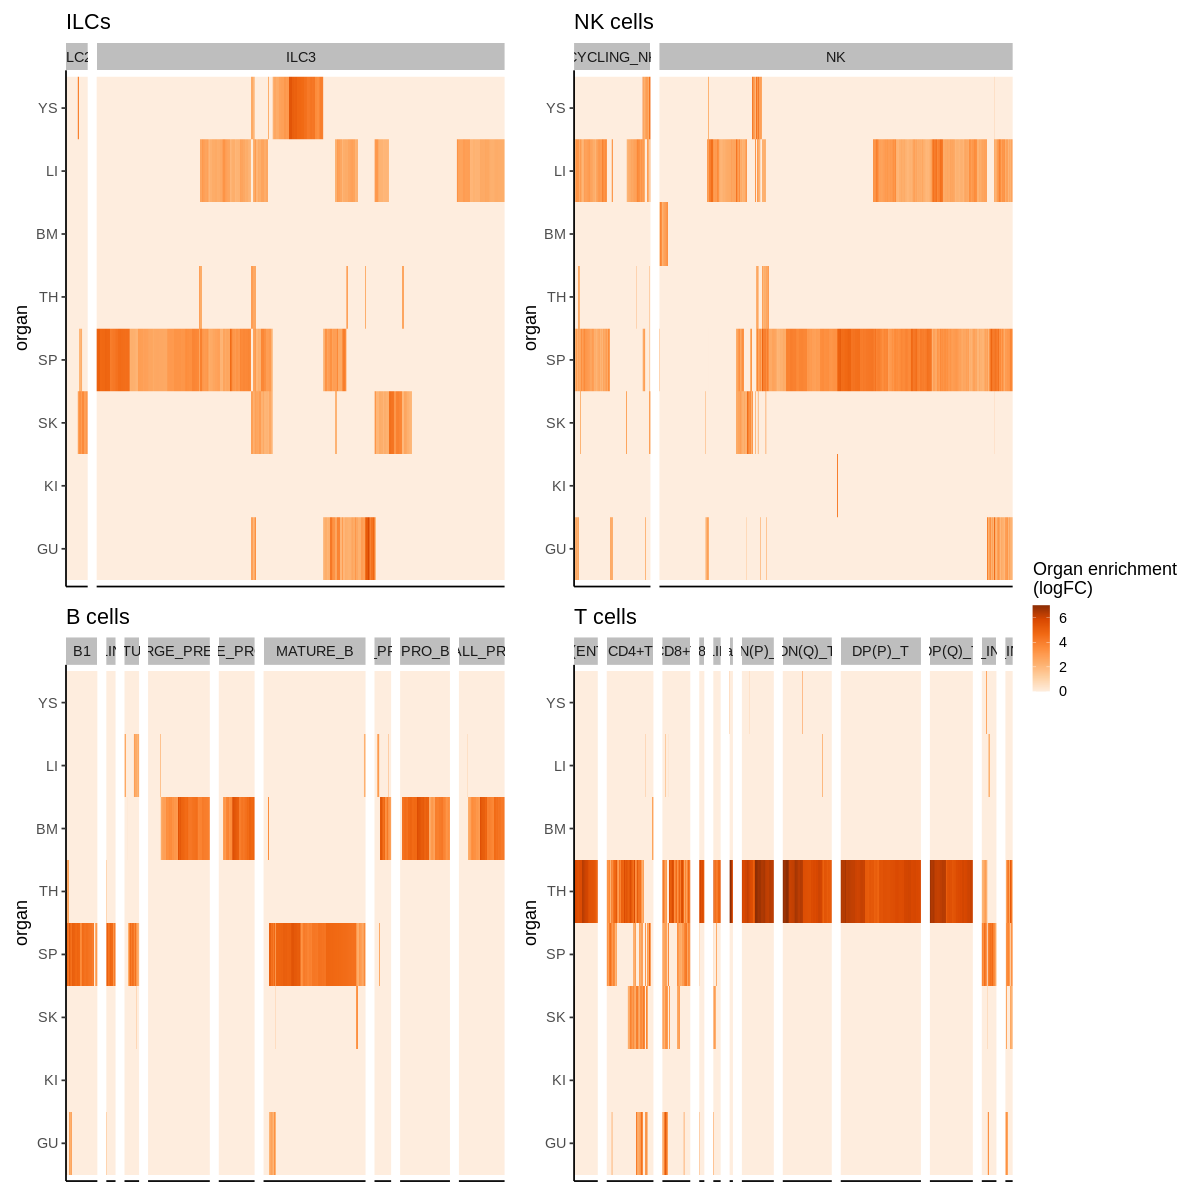

In [49]:
%%R -w 1200 -h 1200
pl_ls <- lapply(c("ILCs", 'NK cells', "B cells", "T cells"), function(g) plot_organ_FC_hm_group(plot_df, g))
wrap_plots(pl_ls, ncol=2, nrow=2) +
    plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'enrichment_hm_all.pdf'), width=20, height=7) +
    ggsave(paste0(figdir, 'enrichment_hm_all.png'), width=20, height=7)

### Save outputs

In [50]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/{s}/'.format(s=split)
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Save dataframe for beeswarm plot
plot_df.to_csv(outdir + "milo_heatmap_plot_data.{s}.csv".format(s=split))

In [51]:
## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
del adata.uns["nhood_adata"]
adata.write_h5ad(outdir + "adata4milo_organ.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_organ_nhood_adata.{s}.h5ad".format(s=split))

... storing 'anno_lvl_2_final_clean' as categorical
... storing 'nhood_annotation' as categorical


### Fig2 plot

In [53]:
long_org_fc = plot_df.copy()

In [54]:
nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata.obs['Nhood'] = [x+1 for x in nhood_adata.obs_names.astype("int")]
plot_nhood_df = nhood_adata.obs[['nhood_annotation_frac', "nhood_annotation", "Nhood", "Nhood_size"]]
graph_df = pd.DataFrame(nhood_adata.obsm['X_milo_graph'])
graph_df.columns = ['milo_graph_X', 'milo_graph_Y']
graph_df.index = nhood_adata.obs_names
plot_nhood_df = pd.concat([plot_nhood_df, graph_df], 1)
plot_nhood_df = pd.merge(plot_nhood_df, long_org_fc)

In [55]:
%%R -i plot_nhood_df
head(plot_nhood_df)

  nhood_annotation_frac nhood_annotation Nhood Nhood_size milo_graph_X
1             0.9462366            CD4+T     1         93    -7.959661
2             0.9462366            CD4+T     1         93    -7.959661
3             0.9462366            CD4+T     1         93    -7.959661
4             0.9462366            CD4+T     1         93    -7.959661
5             0.9462366            CD4+T     1         93    -7.959661
6             0.9462366            CD4+T     1         93    -7.959661
  milo_graph_Y nhood_anno anno_group hclust_order organ    logFC  SpatialFDR
1    -2.011737      CD4+T    T cells          474    SK 3.761364 0.002853998
2    -2.011737      CD4+T    T cells          474    SP 0.000000 0.401569714
3    -2.011737      CD4+T    T cells          474    YS 0.000000 1.000000000
4    -2.011737      CD4+T    T cells          474    LI 0.000000 0.704520354
5    -2.011737      CD4+T    T cells          474    TH 0.000000 0.212952804
6    -2.011737      CD4+T    T cells     

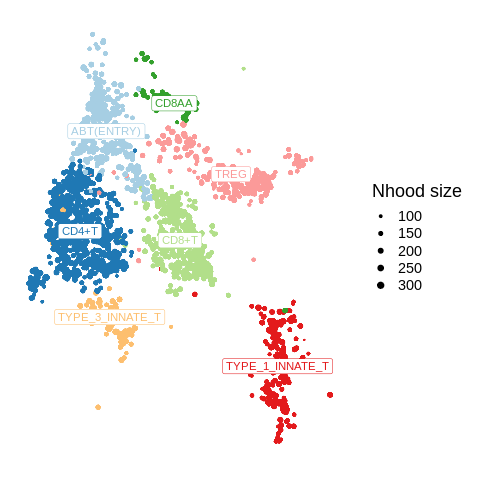

In [62]:
%%R -i figdir
cts_oi = c("CD4+T", "CD8+T", "TYPE_1_INNATE_T", "TYPE_3_INNATE_T", "CD8AA", "ABT(ENTRY)", "TREG")
organs_oi <- c("TH","SP","GU","SK")
p_anno <- plot_nhood_df %>%
    filter(nhood_annotation %in% cts_oi) %>%
    filter(nhood_annotation_frac > 0.5) %>%
    ggplot(aes(milo_graph_X, milo_graph_Y, color=nhood_annotation, size=Nhood_size)) +
    geom_point_rast() +
    geom_label(data = . %>% group_by(nhood_annotation) %>% summarise(milo_graph_X = mean(milo_graph_X),milo_graph_Y = mean(milo_graph_Y)),
               aes(label=nhood_annotation), size=4, fill='white') +
    theme_classic(base_size=18) +
    remove_y_axis() +
    remove_x_axis() +
    guides(color='none', fill='none') +
    scale_color_brewer(palette="Paired") +
    scale_size(name="Nhood size", range=c(0.2,3)) +
    theme(axis.line=element_blank()) +
    coord_fixed()
p_anno

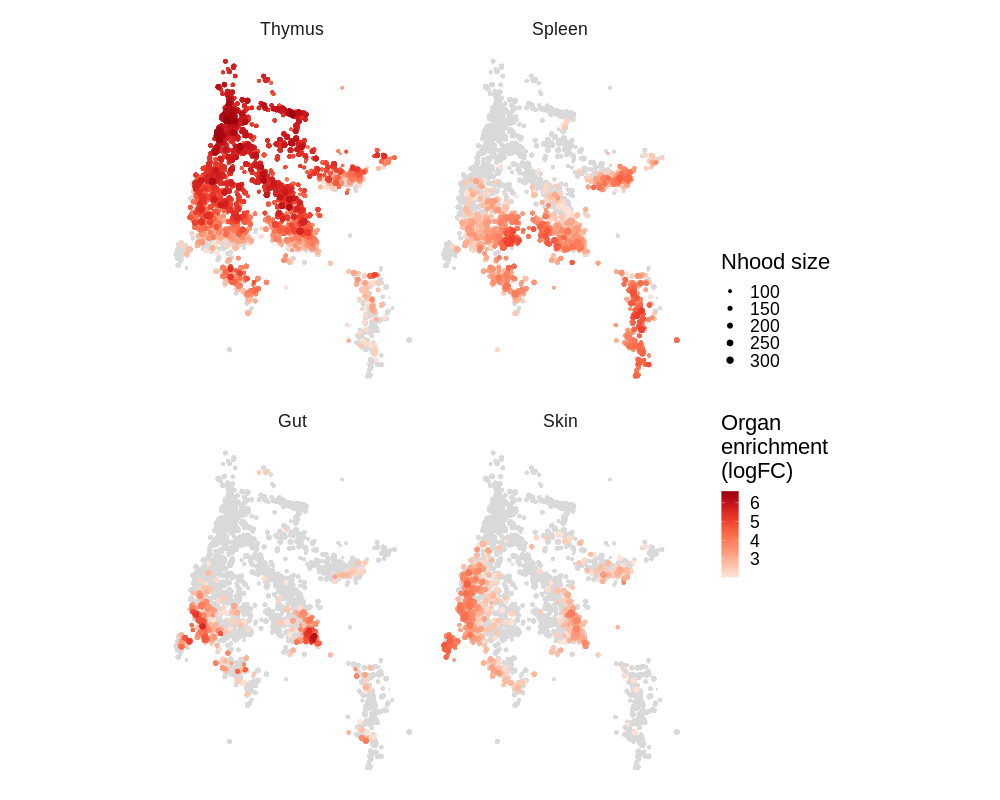

In [63]:
%%R -w 1000 -h 800
org_labels <- list(
    "TH"="Thymus",
    "SP"="Spleen",
    "GU"="Gut",
    "SK" = 'Skin'
    )

org_labeller <- function(variable, value){
    return(org_labels[value])
}

pl2 <- plot_nhood_df %>%
    filter(nhood_annotation %in% cts_oi) %>%
    filter(nhood_annotation_frac > 0.5) %>%
    filter(organ %in% organs_oi) %>%
    mutate(organ=factor(organ, levels=names(org_labels))) %>%
    mutate(logFC = ifelse(SpatialFDR > 0.1 | logFC == 0, NA, logFC)) %>%
    ggplot(aes(milo_graph_X, milo_graph_Y, color=logFC, size=Nhood_size)) +
    geom_point_rast(color='grey85') +
    geom_point_rast(data= . %>% filter(!is.na(logFC)) %>% arrange(logFC)) +
    facet_wrap(organ~., labeller=org_labeller) +
    theme_classic(base_size=22) +
    remove_y_axis() +
    remove_x_axis() +
    scale_color_distiller(palette="Reds", direction=1, name="Organ\nenrichment\n(logFC)") +
    scale_size(name="Nhood size", range=c(0.2,3)) +
    theme(axis.line=element_blank(), strip.background=element_rect(color=NA)) +
    coord_fixed()
    
pl2 

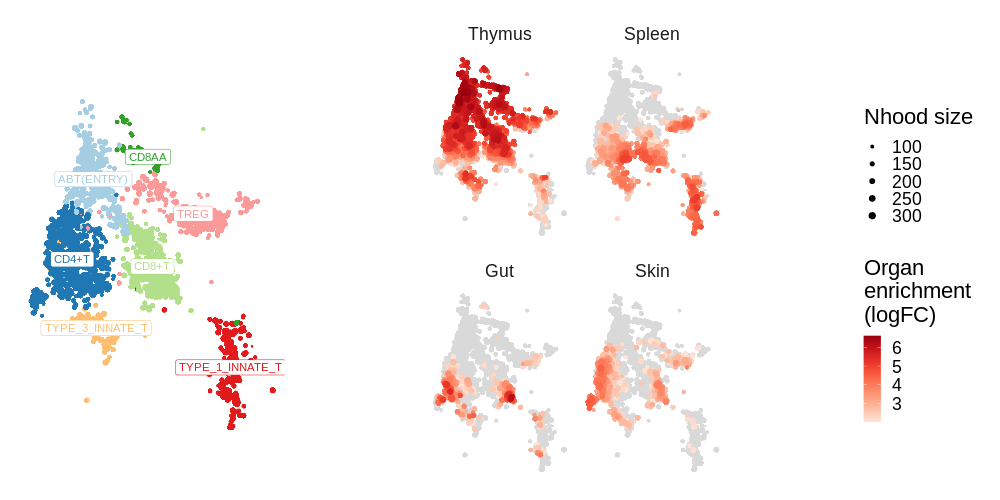

In [65]:
%%R -w 1000 -h 500
library(patchwork)
(p_anno + guides(size='none') + pl2 ) + plot_layout(widths=c(1,2), guides='collect') +
    ggsave(paste0(figdir, 'spt_cells_figure_full.pdf'), width=13, height=9) +
    ggsave(paste0(figdir, 'spt_cells_figure_full.png'), width=13, height=9)

## GSEA plot for significant DGEs

dependencies for enrichr and plotting

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
names = gp.get_library_name() # default: Human

In [11]:
### load DGE results
DGE_path = '/nfs/team205/ed6/data/Fetal_immune/LMM_data/DE_input_HSC_IMMUNE_PBULK/'

In [56]:
### load DGE results
dge = pd.read_csv(DGE_path+'DE_results_TH_vs_rest_TEST_CD4+T-CD8+T-TREG-NK_T-TH17_CTRL_MACROPHAGE_I-NK-MID_ERY.csv')
test = ["CD4+T","CD8+T","TREG","NK_T","TH17"]
ctrl = ["MACROPHAGE_I","NK"]

In [57]:
dge['celltype_type'] = ["condition" if x in test else "ctrl" for x in dge['test_celltype']]

In [58]:
# for positively enriched list
# find genes that adjusted pval < 0.1, lfc > 1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
is_signif_up = (dge['adj_pval']<0.1) & (dge['lfc'] > 1) & (dge['celltype_type'] == 'condition')
genes_signif_up = dge.name[is_signif_up]
genes_signif_up = genes_signif_up.value_counts().index[genes_signif_up.value_counts() >= 3]
is_signif_up_ctrl = (dge['adj_pval']<0.1) & (dge['lfc'] > 0) & (dge['celltype_type'] == 'ctrl')
genes_signif_up_ctrl = dge.name[is_signif_up_ctrl].unique()

# for negatively enriched list
# find genes that adjusted pval < 0.1, lfc < -1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
is_signif_down = (dge['adj_pval']<0.1) & (dge['lfc'] < -1) & (dge['celltype_type'] == 'condition')
genes_signif_down = dge.name[is_signif_down]
genes_signif_down = genes_signif_down.value_counts().index[genes_signif_down.value_counts() >= 3]
is_signif_down_ctrl = (dge['adj_pval']<0.1) & (dge['lfc'] < 0) & (dge['celltype_type'] == 'ctrl')
genes_signif_down_ctrl = dge.name[is_signif_down_ctrl].unique()

genes_signif = np.concatenate([genes_signif_up[~genes_signif_up.isin(genes_signif_up_ctrl)].values,
genes_signif_down[~genes_signif_down.isin(genes_signif_down_ctrl)].values])

dge['significant'] = (dge['name'].isin(genes_signif)) & (dge.celltype_type == 'condition')

In [59]:
## Save for suppl material
dge.to_csv("/home/jovyan/mount/gdrive/Pan_fetal/significant_genes/organ_comparison_DGE/DE_TH_vs_rest_TEST_CD4+T-CD8+T-TREG-NK_T-TH17_CTRL_MACROPHAGE_I-NK-MID_ERY.csv")

In [19]:
# find background set of genes 
background = list(set(dge['name']))

In [140]:
# for positively enriched list
# find genes that adjusted pval < 0.1, lfc > 1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] > 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] > 1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new.loc[tbl_new[0]>2,]
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_THtcells_THvsOther_compiled_poslfc.csv')

# for negatively enriched list
# find genes that adjusted pval < 0.1, lfc < -1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] < 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] < -1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new.loc[tbl_new[0]>2,]
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_THtcells_THvsOther_compiled_neglfc.csv')

In [141]:
df = pd.read_csv('csv/DE_results_THtcells_THvsOther_compiled_neglfc.csv')
gene_list = list(df['index'])

In [ ]:
gene_sets=['MSigDB_Hallmark_2020']

# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 description='test_data',
                 outdir='csv/enrichr/THtcells_THvsOther_compiled_neglfc/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [143]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,7/199,0.000082,0.001223,0,0,7.405928,69.707145,SOCS2;GABARAPL1;AHNAK;CISH;PTGER2;IL18R1;SERPINB6
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/200,0.000084,0.001223,0,0,7.367181,69.111138,NR4A2;SOCS3;PLEK;FOSB;SIK1;JUNB;KLF2
2,MSigDB_Hallmark_2020,Apoptosis,5/161,0.001539,0.014877,0,0,6.390831,41.391066,ANXA1;LMNA;FAS;TSPO;CDC25B
3,MSigDB_Hallmark_2020,Interferon Gamma Response,5/200,0.003932,0.019006,0,0,5.102564,28.260755,SOCS3;FAS;UPP1;SAMHD1;HLA-DRB1
4,MSigDB_Hallmark_2020,Complement,5/200,0.003932,0.019006,0,0,5.102564,28.260755,FCER1G;ITGAM;PLEK;S100A9;CD55


In [208]:
# to save your figure, make sure that ``ofname`` is not None
# ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff = 1,top_terms=5,figsize=(6,6),ofname=fig_path+'BMvsothersCCR2MONO_neglfc_enrichr.pdf')

In [144]:
df = pd.read_csv('csv/DE_results_THtcells_THvsOther_compiled_poslfc.csv')
gene_list = list(df['index'])

In [ ]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 description='test_data',
                 outdir='csv/enrichr/THtcells_THvsOther_compiled_poslfc/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [146]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Interferon Alpha Response,7/97,0.000002,0.000038,0,0,13.267146,172.379138,LGALS3BP;PLSCR1;LAMP3;CMPK2;DDX60;PARP9;IFIT3
1,MSigDB_Hallmark_2020,Hypoxia,9/200,0.000004,0.000038,0,0,8.136952,100.907314,LDHA;P4HA1;RRAGD;AK4;ALDOC;ENO2;HK2;PDK1;VEGFA
2,MSigDB_Hallmark_2020,mTORC1 Signaling,9/200,0.000004,0.000038,0,0,8.136952,100.907314,MLLT11;LDHA;P4HA1;SORD;AK4;BCAT1;HK2;PDK1;MCM2
3,MSigDB_Hallmark_2020,Glycolysis,9/200,0.000004,0.000038,0,0,8.136952,100.907314,LDHA;PKM;P4HA1;PGAM1;RRAGD;AK4;ENO2;HK2;VEGFA
4,MSigDB_Hallmark_2020,Interferon Gamma Response,7/200,0.000240,0.001779,0,0,6.154547,51.287895,LGALS3BP;PLSCR1;OAS3;CMPK2;IFIT1;DDX60;IFIT3


In [212]:
# # to save your figure, make sure that ``ofname`` is not None
# ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff = 1,top_terms=5,figsize=(6,6),ofname=fig_path+'BMvsothersCCR2MONO_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [203]:

enr_neglfc = pd.read_table('csv/enrichr/THtcells_THvsOther_compiled_neglfc/MSigDB_Hallmark_2020.Human.enrichr.reports.txt')
enr_poslfc = pd.read_table('csv/enrichr/THtcells_THvsOther_compiled_poslfc/MSigDB_Hallmark_2020.Human.enrichr.reports.txt')

plot_genes = {
    'markers' : ["TOX2","CD4", "CD8A"],    
    'ifna_genes' :  enr_poslfc.loc[enr_poslfc['Term'] == 'Interferon Alpha Response', "Genes"].values[0].split(';'),
    'tnf_genes' : enr_neglfc.loc[enr_neglfc['Term'] == 'TNF-alpha Signaling via NF-kB', "Genes"].values[0].split(';'),
        
    }

all_plot_genes = sum([v for k,v in plot_genes.items()], [])

In [204]:
gene_anno_df = pd.DataFrame([(x,k) for k,v in plot_genes.items() for x in v])
gene_anno_df.columns = ['gene', 'gene_group']
gene_anno_df.index = gene_anno_df['gene']

In [205]:
all_organs = adata.obs.organ.unique().tolist()

In [206]:
def anndata2pseudobulk(adata, group_by, agg="s", min_ncells = 10):
    '''
    Params:
    ------
    adata: the anndata object
    group_by: list of obs columns to use for aggregation
    agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts), 'n' for n expressing
    min_ncells: minimum number of cells to keep pseudobulk sample (default=10)
    '''
    from scipy.sparse import csr_matrix
    import anndata
    if agg=="s" and "log1p" in adata.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Check that pseudobulk profiles are the sum of all profiles in a sample
    a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
    b = pseudobulk_X[:,0].toarray().flatten()
    if not np.all(a == b):
        print("Error! Aggregation doesn't coincide with sum across the same sample")
        return()
    if agg=="m":
        pseudobulk_X = csr_matrix(pseudobulk_X / sample_dummies.toarray().sum(0))
    if agg=='n':
        adata.X[adata.X != 0] = 1
        pseudobulk_X = adata.X.T.dot(sample_dummies)
        ## Check that pseudobulk profiles are the sum of all profiles in a sample
        a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
        b = pseudobulk_X[:,0].toarray().flatten()
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells]

    return(pseudobulk_adata)

In [207]:
subset_organ = all_organs
subset_anno = ["CD4+T", "CD8+T", "TYPE_1_INNATE_T", "TYPE_3_INNATE_T", "CD8AA", "ABT(ENTRY)", "TREG"]

In [208]:
## mean expression
genes = all_plot_genes
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=['anno_lvl_2_final_clean'], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=['anno_lvl_2_final_clean'], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


<AxesSubplot:xlabel='age_bins', ylabel='IFIT3'>

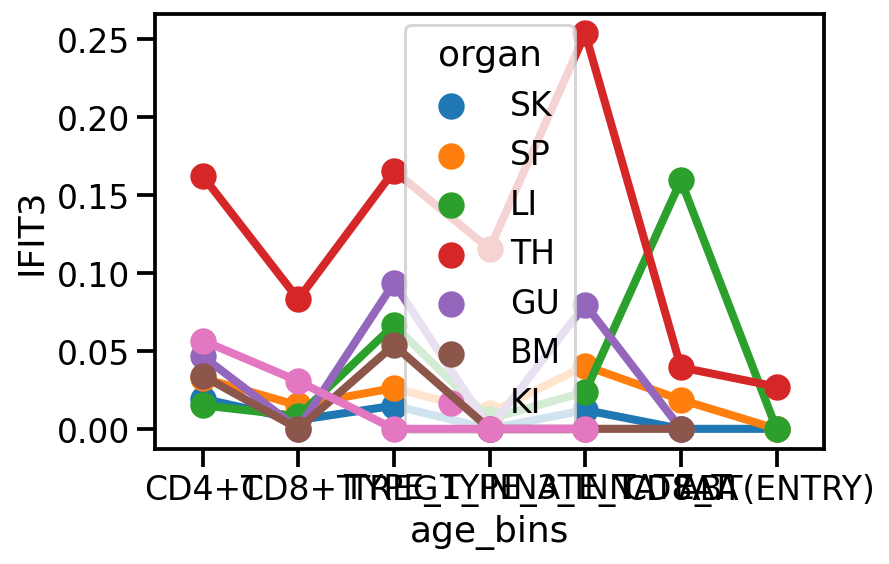

In [209]:
sns.pointplot(data=X_pl_df[['IFIT3', "age_bins", "organ"]], x='age_bins', y='IFIT3', hue='organ')

In [210]:
%%R -i X_pl_df -i N_pl_df -i all_plot_genes -i gene_anno_df
pl_df <- left_join(
        X_pl_df %>% pivot_longer(cols=unlist(unique(all_plot_genes)), names_to="gene", values_to='mean_gex'),
        N_pl_df %>% pivot_longer(cols=unlist(unique(all_plot_genes)), names_to="gene", values_to='n_cells_gex')
        ) %>%
    left_join(gene_anno_df) %>%
    mutate(organ=factor(ifelse(organ!="TH", "other", "TH"), levels=c("TH", "other"))) %>%
#     mutate(organ=ifelse(organ!="TH", "other", "TH")) %>%
    group_by(organ, age_bins, gene, gene_group) %>%
    summarise(mean_gex=mean(mean_gex), n_cells_gex=sum(n_cells_gex), n_cells=sum(n_cells)) %>%
    group_by(gene) %>%
#     mutate(mean_gex=(mean_gex - min(mean_gex))/(max(mean_gex) - min(mean_gex))) 
    mutate(mean_gex=(mean_gex - mean(mean_gex))/(sd(mean_gex))) 

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = "gene"
`summarise()` has grouped output by 'organ', 'age_bins', 'gene'. You can override using the `.groups` argument.


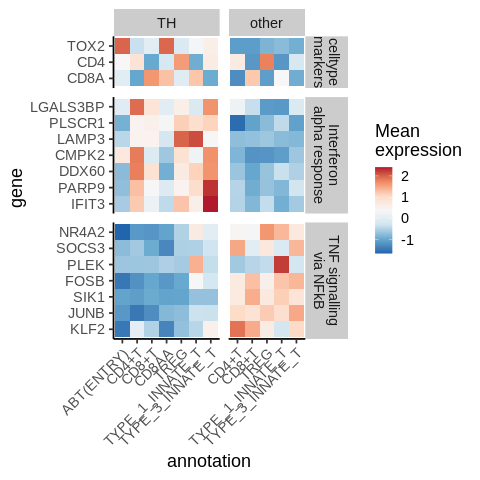

In [219]:
%%R
genesets_labels <- list(
    "markers"="celltype\nmarkers",
    "ifna_genes"="Interferon\nalpha response",
    "tnf_genes" = 'TNF signalling\nvia NFkB'
    )

genesets_labeller <- function(variable, value){
    return(genesets_labels[value])
}

pl_df %>%
    filter(!(age_bins=="CD8AA" & organ=="other")) %>%
    filter(!(age_bins=="ABT(ENTRY)" & organ=="other")) %>%
#     filter(!(age_bins=="MONOCYTE_I_CXCR4" & organ=="other")) %>%
#     filter(!(age_bins=="PROMONOCYTE" & organ=="other")) %>%
    mutate(gene=factor(gene, levels=rev(unlist(unique(all_plot_genes))))) %>%
    mutate(gene_group=factor(gene_group, levels=names(genesets_labels))) %>%
#     mutate(age_bins=factor(age_bins, levels=c("PROMONOCYTE", "MONOCYTE_I_CXCR4", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B"))) %>%
#     mutate(gene=factor(gene, levels=l)) %>%
    ggplot(aes(age_bins, gene)) +
#     geom_point(aes(color=mean_gex, size=n_cells_gex/n_cells)) +
    geom_tile(aes(fill=mean_gex)) +
    facet_grid(gene_group~organ, scales='free', space='free', labeller=labeller(gene_group=genesets_labeller)) +
    scale_color_distiller(palette='RdBu', name='Mean\nexpression') +
    scale_fill_distiller(palette='RdBu', name='Mean\nexpression') +
    xlab("annotation") + 
    theme_classic(base_size=18) +
    scale_size(limits=c(0,1), name="Fraction\nof cells", range=c(0,5)) +
    theme( strip.background=element_rect(color=NA, fill='grey80'), axis.text.x=element_text(angle=45, vjust=1, hjust=1)) +
    ggsave(paste0(figdir, "TH_spt_DEGs_figure_full.pdf"), height=6, width=8)
    